## Lecture 6 - More on Parameter inference

We'll try to fit some data to a skew-normal distribution. We'll see how to estimate ML estimates of the three parameters of the skew-normal distribution using numerical optimization. We'll also explore the notion of bias and variance of an estimator.

In [1]:
# Import several libraries that we'll need

# scipy.stats for various pdf implementations,
# scipy.optimize to numerical calculate MLEs
from scipy import stats, optimize
# various entry-wise calculations
import numpy as np
# plotting
import matplotlib.pyplot as plt

We'll load our data file which contains samples of normalized nanoparticle radii:

(array([0.03955756, 0.01977878, 0.05933634, 0.05933634, 0.05933634,
        0.19778779, 0.21756657, 0.53402704, 0.3757968 , 0.75159361,
        0.90982384, 1.56252355, 1.56252355, 2.15588693, 2.45256862,
        3.12504711, 2.67013519, 2.09655059, 0.77137239, 0.15823023]),
 array([0.40249074, 0.45304998, 0.50360922, 0.55416845, 0.60472769,
        0.65528693, 0.70584617, 0.75640541, 0.80696464, 0.85752388,
        0.90808312, 0.95864236, 1.00920159, 1.05976083, 1.11032007,
        1.16087931, 1.21143855, 1.26199778, 1.31255702, 1.36311626,
        1.4136755 ]),
 <a list of 20 Patch objects>)

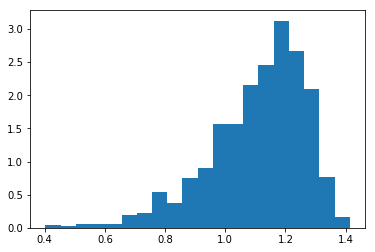

In [38]:
# Load data file
R = np.loadtxt('np_radii.txt')

# Plot histograms with 20 bins:
plt.hist(R, bins=20, density=True)

### Likelihood function for the skewed normal distribution

The skewed normal distribution $SN(\alpha, \mu, \sigma)$ has three parameters. For $R \sim SN(\alpha, \mu, \sigma)$ we'll let $f_R(r; \theta)$ be the pdf of the skewed normal distribution.

Recall that the log likelihood function for iid data $r_i, ..., r_n$ is given by:
$$ \ell(\theta) = \sum_{i=1}^n \log f_R(r_i; \theta).$$

Below we'll define a python function that compute the log likelihood function

In [3]:
# Define log likelihood function for the skewed normal distribution
# - theta is a list with 3 elements: alpha, mu, sigma
# - R is the list of data

def log_likelihood(theta, R):
    alpha = theta[0]
    mu = theta[1]
    sigma = theta[2]
    
    # evaluate the skew norm pdf for each element in R
    # using the stats.skewnorm.pdf(data, alpha, mu, sigma) function
    pdf_vals = stats.skewnorm.pdf(R, alpha, mu, sigma)
    
    # calculate log likelihood componentwise
    ret_val = np.sum(np.log(pdf_vals))
    
    # return the log likelihood
    return ret_val

Once defined, we can try passing in example values of parameters alpha, mu and sigma. Try to see if you can find a set of parameters with large log likelihood. Let's stay within the following bounds:

$$ \alpha \in [-7, 0],$$
$$ \mu \in [0, 3], $$
$$ \sigma \in [0.1, 3],$$

How large a likelihood value can you get by trying random points?

In [4]:
# lets calculate some likelihood values for various random guess of the parameters
alpha = -5
mu = 1.3
sigma = 1

theta = [alpha, mu, sigma]
log_likelihood(theta, R)

-544.3203146907413

### Calling an optimization function

We want to find the optimal value of $\theta$, i.e. the one that maximizes likelihood. There are no closed-form formulas for this ML estimate of the parameters to the skew-normal distribution, so we have to find the optimal values numerically.

We'll use the `scipy.optimize.minimize` function. The three main arguments this function takes are:

1. The function to minimize: This must be the name of a **python function that takes in a single argument** \theta as input.
2. An initial guess of the optimal $\theta$ value
3. Bounds for each variable in $\theta$.

The first point is a bit tricky. We need to specify a python function that takes in a single argument and should be minimized. Instead, we defined a likelihood function above `log_likelihood` that takes in 2 arguments and we wish to maximize this. To quickly define a function that statisfies the requirements of `scipy.optimize.minimize`, we'll use a **lambda expression**, or sometimes called an **anonymous function** in other programming languages.

In [5]:
# we want to use scipy.optimize.minimize function, but we need to 
# pass in as an argument the name of a function that takes the input values only 
# and not the data. We also want to negate it since we want to maximize a function.
# To do this, we'll define an anonymous function

LL = lambda t: -1.0*log_likelihood(t, R)

## LL is a full-fledged python function that we can call. The way we defined it, it takes a single argument
## and calculates the negative of the log likelihood function. Here R is the set of data we read in earlier.

## Let's call it:
theta = [-2, 1.2, 1]
LL(theta)

828.8219098464408

Now that we've defined a function of a single argument that we wish to minimize, we can call the `optimize.minimize function`

In [6]:
theta_guess = [-2, 1.2, 1]
theta_bounds = ((-7, 0), (0, 3), (0.1, 3))

# perform the optimization
res = optimize.minimize(LL, theta_guess, bounds = theta_bounds)

In [7]:
# res is an object with several fields. The one we're interested in is called
# res.x, which contains the optimal theta values.
theta_MLE = res.x
max_log_likelihood = log_likelihood(theta_MLE, R)

alpha_MLE = theta_MLE[0]
mu_MLE = theta_MLE[1]
sigma_MLE = theta_MLE[2]

print('alpha_MLE = ' + str(alpha_MLE))
print('mu_MLE = ' + str(mu_MLE))
print('sigma_MLE = ' + str(sigma_MLE))
print('Maximum log-likelihood = ' + str(max_log_likelihood) )

alpha_MLE = -5.74661014297758
mu_MLE = 1.3090052746628307
sigma_MLE = 0.25743751644792884
Maximum log-likelihood = 508.5235041797873


We can check how good a fit this is by plotting the histogram versus fitted pdf:

Text(0,0.5,'Frequency')

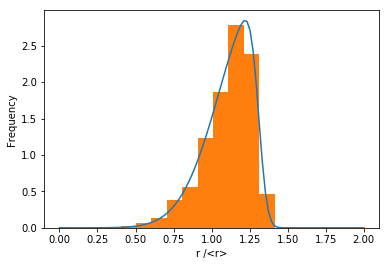

In [268]:
# plot the pdf versus histogram

# the space of radii to plot over
r = np.linspace(0, 2.0, 100)

# evaluate the skew normal pdf at ML estimates
y = stats.skewnorm.pdf(r, alpha_MLE, mu_MLE, sigma_MLE)

# plot pdf
plt.plot(r, y)

# plot histogram
plt.hist(samples, density=True)

plt.xlabel('r /<r>')
plt.ylabel('Frequency')

## Bias and Variance

The ML estimates for $\alpha$, $\mu$ and $\sigma$ all depend on what data we actually saw. **If we were to repeat the experiment again, we'd get different radii and hence different ML estimates of our parameters.** That is, we may think of the MLE - or any estimates - of the parameters as a kind of random variable.

With this perspective, we may ask what distribution these random variables have. In order to do this, we need several data sets. Since we don't have several data sets, **we'll simulate them**.


The strategy here is to:
1. Sample observations from a fixed skew-normal distribution. This will be a simulated, or artificial data set.
2. Use the artificial data set to calculate the ML estimate of our parameters
3. Repeat this lots of times, over several artificial data sets to get a distribution on ML estimates.



In [8]:
# Let's pretend these values are the true values
alpha = alpha_MLE
mu = mu_MLE
sigma = sigma_MLE

# The number of artificial data sets to consider
# each data set gets 1 ML estimate for each parameter
NUM_DATA_SETS = 100

# The number of data points in each artificial data set
NUM_POINTS_PER_DATA_SET = 100

# some arrays to store the sequence of ML estimates of parameters
# one entry per data set.
alpha_MLE_vals = np.zeros(NUM_DATA_SETS)
mu_MLE_vals = np.zeros(NUM_DATA_SETS)
sigma_MLE_vals = np.zeros(NUM_DATA_SETS)

# simulate "NUM_DATA_SETS" artificial data sets
for i in range(NUM_DATA_SETS):
    
    # generate an artificial data set by sampling from the skew-normal distribution
    sample_i = stats.skewnorm.rvs(alpha, mu, sigma, NUM_POINTS_PER_DATA_SET)

    # define negative log likelihood wrt to this data
    LL = lambda theta: -1.0*log_likelihood(theta, sample_i)

    # optimize to get ML estimates of parameters
    res = optimize.minimize(LL, [-2, 1.2, 1], bounds=((-7, 0), (0, 3), (0.1, 3)))
    theta_MLE = res.x
    
    # save the ML estimates 
    alpha_MLE_vals[i] = theta_MLE[0]
    mu_MLE_vals[i] = theta_MLE[1]
    sigma_MLE_vals[i] = theta_MLE[2]


Now lets look at the distributions for the various parameters. First we'll start with the $\alpha$ parameter. Recall the true value (i.e. the value were were using to sample artificial data was $\alpha = -5.75$.

True value for alpha = -5.746612042440025
Mean of alpha_MLE from sampling distribution = -5.784065441920948


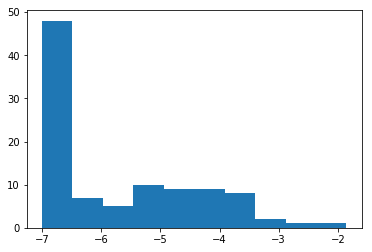

In [297]:
plt.hist(alpha_MLE_vals)

print('True value for alpha = ' + str(alpha))
print('Mean of alpha_MLE from sampling distribution = ' + str(np.mean(alpha_MLE_vals)))

True value for mu = 1.3090052566229706
Mean of mu_MLE from sampling distribution = 1.304225212589224


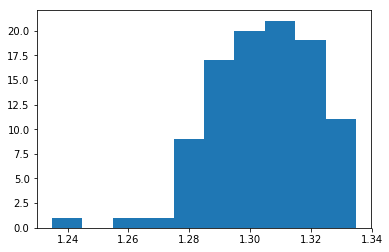

In [298]:
plt.hist(mu_MLE_vals)

print('True value for mu = ' + str(mu))
print('Mean of mu_MLE from sampling distribution = ' + str(np.mean(mu_MLE_vals)))

True value for sigma = 0.25743759182399323
Mean of sigma_MLE from sampling distribution = 0.2536571078206856


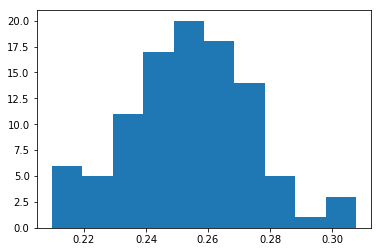

In [299]:
plt.hist(sigma_MLE_vals)

print('True value for sigma = ' + str(sigma))
print('Mean of sigma_MLE from sampling distribution = ' + str(np.mean(sigma_MLE_vals)))

## Bayesian parameter inference

Now we'll consider parameter inference from the Bayesian perspective. Recall from the slides that the posterior distribution for the parameter given data is the likelihood of the parameter times its prior:


$$f_{\Theta | X = x}(\theta) = f_{X| \Theta = \theta}(x) \cdot f_\Theta(\theta)$$

We'll consider a single observation $x$ of a RV $X \sim \mathcal N(\Theta, \sigma^2)$ with unknown mean $\Theta$. In the Bayesian perspective, since we don't know $\Theta$, we'll treat it as a random variable as well, and assign in a prior distribution, $\Theta \sim \mathcal N(a, b)$. We assume we know $\sigma^2, a, b$.

Let's compare the posterior distribution $f_{\Theta | X = x}(\theta)$ versus the prior distribution $f_{\Theta}(\theta)$.


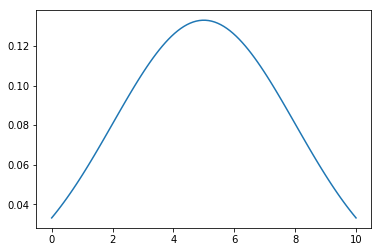

In [302]:
# Define the domain over which to plot
theta = np.linspace(0, 10, 100)

# Define the prior distribution parameters
a = 5
b = 3

# evaluate the prior distribution
prior_theta = stats.norm.pdf(theta, a, b)

plt.plot(theta, prior_theta)


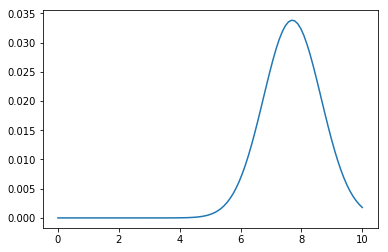

In [304]:
# Here, x is an "observation" of the RV X. Let's pretend we observed x = 8
x = 8

# We'll set sigma = 1
sigma = 1

# calculate the likelihood
likelihood_theta = stats.norm.pdf(x-theta, 0, sigma)

# calculate the posterior (unnormalized)
posterior_theta = likelihood_theta*prior_theta

# plot the posterior
plt.plot(theta, posterior_theta)

In [ ]:
# Play around with X, sigma. 
# What do they represent?

In [37]:
R

array([6.4856918 , 1.19556299, 1.07618929, 1.19946213, 0.91441917,
       1.28712213, 1.20492297, 1.29470598, 1.26188747, 1.01624306,
       1.20558936, 1.2444335 , 1.20447212, 1.10041643, 1.13302522,
       0.78005908, 1.18291769, 1.06789371, 1.04686963, 1.14216798,
       0.92032682, 1.34611132, 1.1517804 , 1.18994501, 1.13839598,
       0.91383166, 1.31644139, 1.23679238, 1.12913055, 0.9610382 ,
       0.86726504, 1.11359063, 1.07403049, 1.15884913, 1.14549945,
       1.3249777 , 0.76627218, 1.23137785, 0.9925694 , 1.15861206,
       1.07469101, 1.16066894, 1.16260284, 1.29720975, 1.15926362,
       1.18441817, 1.1838899 , 1.0407966 , 1.28254116, 1.27209714,
       1.25566644, 0.95492958, 1.25812991, 0.96761903, 1.12082034,
       1.19371235, 1.24956051, 1.13633703, 1.09504833, 1.16304178,
       0.97280237, 1.14318067, 1.12800618, 1.11963133, 1.03405634,
       1.29770577, 1.22786013, 0.96321301, 1.1255914 , 1.24459516,
       0.97629373, 1.05503786, 0.70646539, 1.05531594, 1.13033

1.0809486337501877
1.6214229506252815


1.3131313131313131

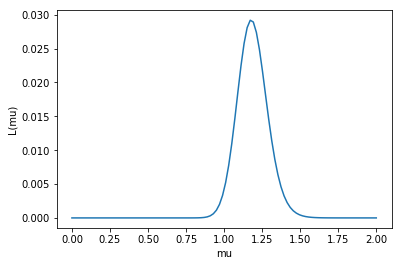

In [66]:
# SCRATCH

# the space of mu values for the skew normal distirbution
MU = np.linspace(0, 2, 100)

# deep copy
data = [r for r in R]
print(data[0])

# put an outlier
data[0] = 1.5*data[0]
print(data[0])

# the likelihood function for the small set of data, and use MLE estimates for alpha and sigma
L_mu = lambda m: np.exp(log_likelihood([alpha_MLE, m, sigma_MLE], data))

# the likelihood values L(mu) for every element in MU array
likelihood = [L_mu(mu) for mu in MU]

# plot likelhood function
plt.plot(MU, y)
plt.xlabel('mu')
plt.ylabel('L(mu)')

# max likelihood
i_max_likelihood = np.argmax(likelihood)
MU[i_max_likelihood]

1.3131313131313131

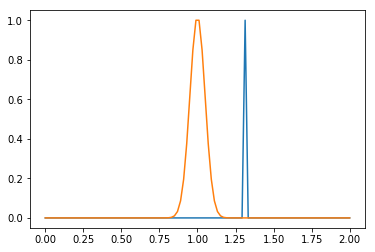

In [67]:
# gaussian prior on A
prior = stats.norm.pdf(MU, 1, 0.05)

posterior = likelihood*prior
plt.plot(MU, posterior/np.max(posterior))
plt.plot(MU, prior/np.max(prior))

i_max_likelihood = np.argmax(posterior)
MU[i_max_likelihood]